>> This section is the modeling phase for M-1 model

In [1]:
'''
    Importing required python libraries
'''

import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

try:
    import tensorflow as tf
    import keras
except:
    !pip install tensorflow
    !pip install keras
    import tensorflow as tf
    import keras

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
layers = keras.layers

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
'''
    Reading list of integer and float variables stored in file_list directory
    Also naming out model and history file
'''

cols_to_drop = ['memshpno', 'Bought_brand']

_int = pd.read_csv('file_list/int_var.txt', header=None)
_int = list(_int[0])
print('# of integer columns: {}'.format(len(_int)))

_float = pd.read_csv('file_list/float_var.txt', header=None)
_float = list(_float[0])
print('# of float columns: {}'.format(len(_float)))

model_name = 'best_model_wt_1.h5'
history_file = 'model_history/trainHistory_wt_1'

# of integer columns: 512
# of float columns: 1125


In [3]:
'''
    This chunk imports the lists of training and validation file names stored during preprocessing
'''

train_files = pd.read_csv('file_list/train_files.txt', header=None)
train_files = list(train_files[0])
validation_files = pd.read_csv('file_list/validation_files.txt', header=None)
validation_files = list(validation_files[0])

In [4]:
''' 
    Generator Function reads csvs from list with each csv individually read in chunks of 5000 records 
'''

def train_generator(file_list):
    import os
    while True:
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], chunksize=5000)
            for chunk in df:
                chunk = chunk.fillna(0)
                label = chunk['Bought_brand']
                chunk.drop(cols_to_drop, axis=1, inplace=True)
                deep = chunk[_float]
                wide = chunk[_int]
                inputs = [wide.values, deep.values]
                yield inputs, label

In [5]:
''' 
    Generator Function reads csvs from list with each csv individually read in chunks of 5000 records 
'''

def generator(file_list):
    import os
    while True:
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], chunksize=5000)
            for chunk in df:
                chunk = chunk.fillna(0)
                label = chunk['Bought_brand']
                chunk.drop(cols_to_drop, axis=1, inplace=True)
                deep = chunk[_float]
                wide = chunk[_int]
                inputs = [wide.values, deep.values]
                yield inputs, label

In [6]:
''' 
    Keras model architecture (deep and wide architecture)
'''

wide_inputs = layers.Input(shape=(len(_int),))
wide_inputs_1 = layers.Dense(128, activation='relu')(wide_inputs)
wide_inputs_2 = layers.Dense(64, activation='relu')(wide_inputs_1)
wide_inputs_3 = layers.Dense(32, activation='relu')(wide_inputs_2)

dense_inputs = layers.Input(shape=(len(_float),))
dense_inputs_1 = layers.Dense(128, activation='relu')(dense_inputs)
dense_inputs_2 = layers.Dense(64, activation='relu')(dense_inputs_1)
dense_inputs_3 = layers.Dense(32, activation='relu')(dense_inputs_2)

merge = layers.concatenate([wide_inputs_3, dense_inputs_3])

hidden1 = layers.Dense(32, activation='relu')(merge)
hidden2 = layers.Dense(16, activation='relu')(hidden1)
output = layers.Dense(1, activation='sigmoid')(hidden2)

model = keras.Model(inputs=[wide_inputs, dense_inputs], outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
''' 
    Visualizing model architecture
'''

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1125)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          65664       input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 128)          144128      input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (D

In [8]:
''' 
    Initializing train and validation generators
'''

train_g = train_generator(train_files)
validation_g = generator(validation_files)

In [9]:
''' 
    Early Stopping and Call Backs 
'''

model_path = "model"
path = os.path.join(model_path, model_name)
callbacks = [EarlyStopping(monitor='val_loss', patience=3), 
                 ModelCheckpoint(filepath=path, monitor='val_loss', save_best_only=True)]

In [ ]:
''' 
    Model execution
'''

final_model = model.fit_generator(train_g, epochs=10, steps_per_epoch=(len(train_files)*5), \
                                  validation_data=validation_g, validation_steps=(len(validation_files)*4), \
                                 callbacks=callbacks, max_q_size=1, use_multiprocessing=True)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
753/900 [========================>.....] - ETA: 3:15 - loss: 0.1045 - acc: 0.8618

In [ ]:
''' 
    Saving model history for future visualization
'''

with open(history_file, 'wb') as handle: 
    pickle.dump(final_model.history, handle)

In [ ]:
''' 
    Plotting training and validation loss
'''

# plot training and validation loss
training_loss = final_model.history['loss']
test_loss = final_model.history['val_loss']

epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

In [ ]:
''' 
    Plotting training and validation accuracies
'''

# Get training and validation accuracies
training_acc = final_model.history['acc']
test_acc = final_model.history['val_acc']

epoch_count = range(1, len(training_acc) + 1)

plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

# Test Section

>> This is the test section where unseen test data is predicted through the M-1 model created in previous section. Following section extract labels on the validation dataset as well

In [1]:
'''
    Importing required python libraries
'''

import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.utils import shuffle

try:
    import tensorflow as tf
    import keras
except:
    !pip install tensorflow
    !pip install keras
    import tensorflow as tf
    import keras

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
layers = keras.layers

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
'''
    Reading list of integer and float variables stored in file_list directory
    Also naming out model and history file
'''

cols_to_drop = ['memshpno', 'Bought_brand']

_int = pd.read_csv('file_list/int_var.txt', header=None)
_int = list(_int[0])
print('# of integer columns: {}'.format(len(_int)))

_float = pd.read_csv('file_list/float_var.txt', header=None)
_float = list(_float[0])
print('# of float columns: {}'.format(len(_float)))

model_name = 'best_model_wt_1.h5'
history_file = 'model_history/trainHistory_wt_1'

# of integer columns: 512
# of float columns: 1125


In [3]:
''' 
    Generator Function reads csvs from list with each csv individually read in chunks of 5000 records 
'''

def generator(file_list):
    import os
    while True:
        for i in range(len(file_list)):
            df = pd.read_csv(file_list[i], chunksize=5000)
            for chunk in df:
                chunk = chunk.fillna(0)
                label = chunk['Bought_brand']
                chunk.drop(cols_to_drop, axis=1, inplace=True)
                deep = chunk[_float]
                wide = chunk[_int]
                inputs = [wide.values, deep.values]
                yield inputs, label

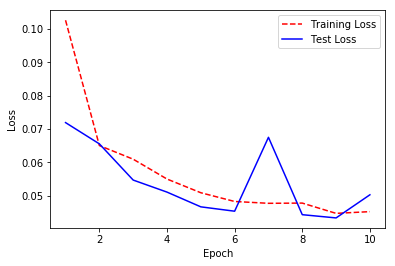

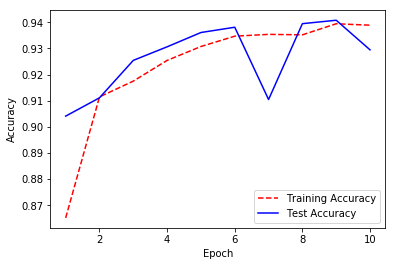

In [4]:
''' 
    Plotting training and validation loss and accuracies
'''

try:
    history = pickle.load(open(history_file, 'rb'))

    # plot training and validation loss
    training_loss = history['loss']
    test_loss = history['val_loss']

    epoch_count = range(1, len(training_loss) + 1)

    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Test Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

    # Get training and validation accuracies
    training_acc = history['acc']
    test_acc = history['val_acc']

    epoch_count = range(1, len(training_acc) + 1)

    plt.plot(epoch_count, training_acc, 'r--')
    plt.plot(epoch_count, test_acc, 'b-')
    plt.legend(['Training Accuracy', 'Test Accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show();
except:
    pass

In [5]:
'''
    This chunk imports the lists of test file names stored during preprocessing
'''

test_files = pd.read_csv('file_list/test_files.txt', header=None)
test_files = list(test_files[0])

In [6]:
'''
    Loading model and initializing test generator
'''

model_path = "model"
model = load_model(os.path.join(model_path, model_name))
test_generator = generator(test_files)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [7]:
'''
    Loading original test labels for comparison with predictions
'''

original_labels = pd.read_csv('file_list/test_labels.csv')
original_labels.head()

,memshpno,Bought_brand
0,110000106810,0
1,110000108481,0
2,110000109446,1
3,110000109772,0
4,110000110087,0


In [8]:
'''
    Predicitons
'''

predictions = model.predict_generator(test_generator, steps=len(test_files)*5, verbose=1)

50/50 [==============================] - 61s 1s/step


In [9]:
'''
    Adding predictions to original labels
'''

new_prediction_labels = pd.DataFrame(predictions)
new_prediction_labels.columns = ['propensity']

In [10]:
'''
    Calculating optimal cut_off using area under curve
'''

import sklearn.metrics as metrics

AUC_score = []
for i in range(1, 100):
    new_prediction_labels['label'] = 0
    new_prediction_labels['label'][new_prediction_labels['propensity']>i/100] = 1
    fpr, tpr, threshold = metrics.roc_curve(original_labels['Bought_brand'], new_prediction_labels['label'])
    roc_auc = metrics.auc(fpr, tpr)
    AUC_score.append([i/100, roc_auc])
    print(i, end='\r')

In [11]:
'''
    Calculating optimal cut_off using area under curve
'''

AUC_score = pd.DataFrame(AUC_score)
AUC_score.columns = ['threshold', 'auc']
AUC_score.sort_values(by=['auc'], inplace=True, ascending=False)
AUC_score.head()

,threshold,auc
18,0.19,0.921090
19,0.20,0.920970
21,0.22,0.920881
20,0.21,0.920873
22,0.23,0.920863


In [12]:
'''
    Confusion matrix with best cut_off
'''

new_prediction_labels['label'] = 0
new_prediction_labels['label'][new_prediction_labels['propensity']>AUC_score.iloc[0][0]] = 1
print(classification_report(original_labels['Bought_brand'], new_prediction_labels['label'], target_names=None))

             precision    recall  f1-score   support

          0       0.98      0.91      0.95    197700
          1       0.68      0.93      0.78     38620

avg / total       0.93      0.92      0.92    236320



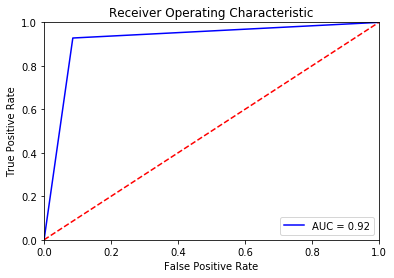

In [13]:
'''
    Plotting area under curve
'''

fpr, tpr, threshold = metrics.roc_curve(original_labels['Bought_brand'], new_prediction_labels['label'])
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Accuracy on Validation Set

In [14]:
'''
    This chunk imports the lists of validation file names store during preprocessing
'''

test_files = pd.read_csv('file_list/validation_files.txt', header=None)
test_files = list(test_files[0])

In [15]:
'''
    Loading model and initializing test generator
'''

model_path = "model"
model = load_model(os.path.join(model_path, model_name))
test_generator = generator(test_files)

In [16]:
'''
    Loading original test labels for comparison with predictions
'''

original_labels = pd.read_csv('file_list/validation_labels.csv')
original_labels.head()

,memshpno,Bought_brand
0,110000107350,1
1,110000110182,0
2,110000112524,0
3,110000112887,0
4,110000115262,0


In [17]:
'''
    Predicitons
'''

predictions = model.predict_generator(test_generator, steps=len(test_files)*5, verbose=1)

50/50 [==============================] - 51s 1s/step


In [18]:
'''
    Adding predictions to original labels
'''

new_prediction_labels = pd.DataFrame(predictions)
new_prediction_labels.columns = ['propensity']

In [19]:
'''
    Calculating optimal cut_off using area under curve
'''

import sklearn.metrics as metrics

AUC_score = []
for i in range(1, 100):
    new_prediction_labels['label'] = 0
    new_prediction_labels['label'][new_prediction_labels['propensity']>i/100] = 1
    fpr, tpr, threshold = metrics.roc_curve(original_labels['Bought_brand'], new_prediction_labels['label'])
    roc_auc = metrics.auc(fpr, tpr)
    AUC_score.append([i/100, roc_auc])
    print(i, end='\r')

In [20]:
'''
    Calculating optimal cut_off using area under curve
'''

AUC_score = pd.DataFrame(AUC_score)
AUC_score.columns = ['threshold', 'auc']
AUC_score.sort_values(by=['auc'], inplace=True, ascending=False)
AUC_score.head()

,threshold,auc
18,0.19,0.919475
19,0.20,0.919430
20,0.21,0.919402
21,0.22,0.919266
17,0.18,0.919256


In [21]:
'''
    Confusion matrix with best cut_off
'''

new_prediction_labels['label'] = 0
new_prediction_labels['label'][new_prediction_labels['propensity']>AUC_score.iloc[0][0]] = 1
print(classification_report(original_labels['Bought_brand'], new_prediction_labels['label'], target_names=None))

             precision    recall  f1-score   support

          0       0.98      0.91      0.95    196912
          1       0.68      0.92      0.78     38620

avg / total       0.93      0.92      0.92    235532



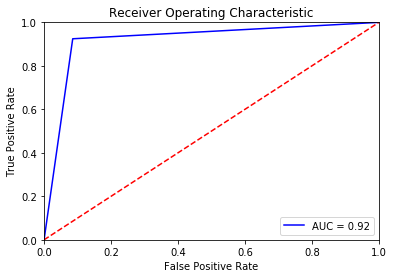

In [22]:
'''
    Plotting area under curve
'''

fpr, tpr, threshold = metrics.roc_curve(original_labels['Bought_brand'], new_prediction_labels['label'])
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()